In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mxnet 
from mxnet.gluon import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [47]:
finalData = pd.read_csv('../data/ReadyData.csv')

In [48]:
lst = ["datetime"] + list(finalData.columns)[1:]
lst

['datetime',
 'PM2.5',
 'USAQI',
 'CO2',
 'Temperature',
 'RelativeHumidity',
 'weekday',
 'hour',
 'month',
 'year',
 'dayofmonth',
 'drct',
 'sped',
 'vsby']

In [49]:
finalData.columns = lst

In [50]:
finalData.drop("datetime", axis = 1, inplace = True)

In [51]:
mean = finalData.mean()
min = finalData.min()
max = finalData.max()
finalData = finalData.apply(lambda x: (x - np.mean(x)) / (np.std(x)))
finalData = pd.DataFrame(finalData["PM2.5"])

In [52]:
name = list(finalData.columns)
cols, names = list(), list()
for i in range(5, 0, -1): #5 times steps
    cols.append(finalData.shift(i))
    names += [('%s(t-%d)' % (name[j], i)) for j in range(finalData.shape[1])]
cols.append(finalData.shift(-0))
names += ["PM2.5"]
finalDataset = pd.concat(cols, axis=1)
finalDataset.columns = names
finalDataset = finalDataset[5:]

display(finalDataset.head())

,PM2.5(t-5),PM2.5(t-4),PM2.5(t-3),PM2.5(t-2),PM2.5(t-1),PM2.5
5,5.171740,4.783023,4.705280,3.124499,2.782428,3.041573
6,4.783023,4.705280,3.124499,2.782428,3.041573,3.518398
7,4.705280,3.124499,2.782428,3.041573,3.518398,3.860469
8,3.124499,2.782428,3.041573,3.518398,3.860469,4.005590
9,2.782428,3.041573,3.518398,3.860469,4.005590,4.119613


In [53]:
finalDataset.reset_index(drop = True)
labels = finalData["PM2.5"]
finalDataset.drop("PM2.5", axis = 1, inplace = True)


In [55]:
#we have data for a total of 20 months, let's train (roughly) for 16 months, and test for the remaining 4.
trainDataX = finalDataset[:30*16*24]
testDataX = finalDataset[30*16*24:]
trainDataY = labels[:30*16*24]
testDataY = labels[30*16*24:]




In [56]:
finalDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14587 entries, 5 to 14591
Data columns (total 5 columns):
PM2.5(t-5)    14587 non-null float64
PM2.5(t-4)    14587 non-null float64
PM2.5(t-3)    14587 non-null float64
PM2.5(t-2)    14587 non-null float64
PM2.5(t-1)    14587 non-null float64
dtypes: float64(5)
memory usage: 569.9 KB


In [57]:
from mxnet import nd
finalDataset = nd.array(finalDataset).reshape(-1, 5, 1)
trainDataX = nd.array(trainDataX).reshape(-1, 5, 1)
testDataX = nd.array(testDataX).reshape(-1, 5, 1)

In [58]:
trainDataY = nd.array(trainDataY)
testDataY = nd.array(testDataY)

In [85]:
model = mxnet.gluon.nn.Sequential()
model.add(mxnet.gluon.rnn.LSTM(10, 1, dropout = 0.4))
model.add(mxnet.gluon.nn.Dense(1, activation='relu'))

model.initialize(mxnet.init.Xavier())

trainer = mxnet.gluon.Trainer(
    params=model.collect_params(),
    optimizer='adam',
    optimizer_params={'learning_rate': 0.01}
)

In [86]:
loss = mxnet.gluon.loss.L2Loss()
error = mxnet.metric.MSE()

In [87]:
epochs = 10
trainingLoss = []
train_iter = mxnet.io.NDArrayIter(trainDataX, trainDataY, 12, shuffle=True)
for epoch in range(epochs):
    for trn_batch in train_iter:
        x = trn_batch.data[0]
        y = trn_batch.label[0]
        
        with mxnet.autograd.record():
            y_pred = model(x)
            im_loss = loss(y_pred, y)
        
        #backprop
        im_loss.backward()
        
        #Optimize!
        trainer.step(batch_size=12)
        
    train_iter.reset()
    
    # Calculate train metrics
    
    predictions = model(trainDataX)
    error.update(trainDataY, predictions)
    trainingLoss.append(error.get()[1])
    error.reset()
    
    train_iter.reset()
    
    print("epoch: {} | trn_loss: {:.8f}".format(epoch+1,
                                                trainingLoss[-1]))


epoch: 1 | trn_loss: 0.29411298
epoch: 2 | trn_loss: 0.29375750
epoch: 3 | trn_loss: 0.29186428
epoch: 4 | trn_loss: 0.29414484
epoch: 5 | trn_loss: 0.29149702
epoch: 6 | trn_loss: 0.29296738
epoch: 7 | trn_loss: 0.29203111
epoch: 8 | trn_loss: 0.29338166
epoch: 9 | trn_loss: 0.29133397
epoch: 10 | trn_loss: 0.29102880


In [88]:
print(y_pred)


[[0.7825494]
 [3.765838 ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]
 [0.       ]]
<NDArray 12x1 @cpu(0)>


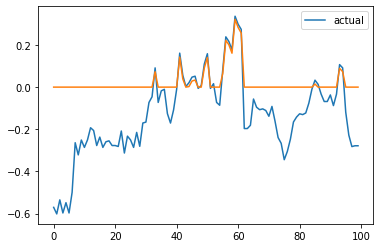

In [89]:
predictions = model(testDataX)
plt.plot(testDataY[:100].asnumpy(), label = 'actual')
plt.plot(predictions[:100].asnumpy())
plt.legend()
plt.savefig("Univariate_LSTM_10_1_relu.pdf")